In [2]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
with open('names.txt', 'r', encoding='utf-8') as f:
    text = f.read().split('\n')

# Unique characters in the text
chars = ['.'] + sorted(list(set(''.join(text))))
vocab_size = len(chars)

# Mapping from characters to integers and vice versa
char_to_int = {c: i for i, c in enumerate(chars)}
int_to_char = {i: c for i, c in enumerate(chars)}

# B - batch size, T - block size, C - embedding dimension (vocab size)

In [4]:
block_size = 3 # Context length for predictions

def build_dataset(text: list[str]) -> tuple[torch.Tensor, torch.Tensor]:
    """Builds the dataset for training the model."""
    X, Y = [], []
    for word in text:
        context = [0] * block_size # Padding the context with initial '.' characters
        for char in word + '.':
            ix = char_to_int[char]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # Update context
    return torch.tensor(X), torch.tensor(Y)

random.shuffle(text)
split = int(len(text) * 0.9) # 90% train, 10% val

x_train, y_train = build_dataset(text[:split])
x_val, y_val = build_dataset(text[split:])

### Batch Normalisation

In [5]:
n_embd = 2 # Embedding dimension
n_hidden = 200 # Neurons in the hidden layer

C = torch.randn((vocab_size, n_embd)) # Embedding table (B,T) -> (B,T,C)
# Hidden layer
kaiming_init = (5/3) / (block_size * n_embd) ** 0.5
W_hidden = torch.randn((block_size * n_embd, n_hidden)) * kaiming_init
# Output layer
W_out = torch.randn((n_hidden, vocab_size)) * 0.01 # Initialised to small values
b_out = torch.randn(vocab_size) * 0 # Initialised to zero

# Batch normalisation params
bn_gain = torch.ones((1, n_hidden))
bn_bias = torch.zeros((1, n_hidden))
bn_mean_live = torch.zeros((1, n_hidden))
bn_std_live = torch.ones((1, n_hidden))

params = [C, W_hidden, W_out, b_out, bn_gain, bn_bias]
for param in params:
    param.requires_grad = True

print(f'Model parameters: {sum(param.nelement() for param in params)}')

Model parameters: 7081


Initialising the weights in the output layer to be small random values ensures that the network is not confidently wrong about the output (and so has a high loss). This decreases the initial loss and allows the network to learn more effectively as it does not have to spend the first few training iterations correcting the initial large errors and can instead spend more time optimising the weights to reduce the loss.

### Finding a Suitable Learning Rate

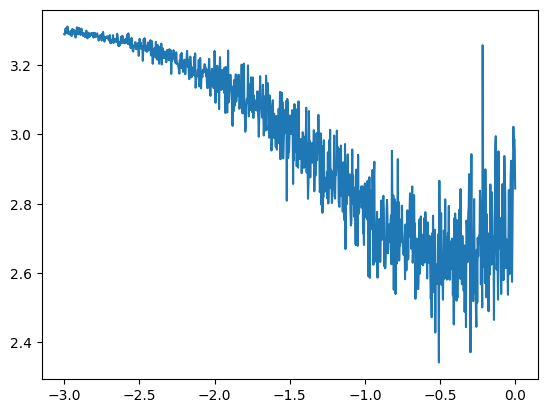

In [6]:
batch_size = 128 # Number of samples per batch
max_iters = 1000

lrs_exp = torch.linspace(-3, 0, max_iters) # Linearly decrease the learning rate from 1e-3 to 1e-0
lrs = 10 ** lrs_exp

# Mini-batch gradient descent
losses = []
for i in range(max_iters):

    ix = torch.randint(0, x_train.shape[0], (batch_size, )) # Mini-batches
    xb, yb = x_train[ix], y_train[ix]

    # Forward pass
    emb = C[xb] # Embed characters into vectors (B,T) -> (B,T,C)
    emb = emb.view(emb.size(0), -1)  # Concatenate the embeddings (B,T,C) -> (B,TC)
    h_pre_act = emb @ W_hidden

    # Batch normalisation
    bn_mean_i = h_pre_act.mean(0, keepdim=True)
    bn_std_i = h_pre_act.std(0, keepdim=True)
    h_pre_act = bn_gain * (h_pre_act - bn_mean_i) / bn_std_i + bn_bias
    with torch.no_grad():
        bn_mean_live = 0.999 * bn_mean_live + 0.001 * bn_mean_i
        bn_std_live = 0.999 * bn_std_live + 0.001 * bn_std_i
        
    h = torch.tanh(h_pre_act)
    logits = h @ W_out + b_out

    # Cross entropy loss
    loss = F.cross_entropy(logits, yb)
    losses.append(loss.data)

    # Backward pass
    for param in params:
        param.grad = None # Set the gradient to zero
    loss.backward()

    # Update the parameters
    for param in params:
        param.data -= lrs[i] * param.grad

# Plot the mini-batch loss vs. learning rate
plt.plot(lrs_exp, losses)

The data shows the best learning rate occurs at roughly 1e-1.

### Training the Model with a Split Learning Rate

Iteration  0 | Loss (Mini-Batch): 2.4560
Iteration 50 | Loss (Mini-Batch): 2.4354
Iteration 100 | Loss (Mini-Batch): 2.3828
Iteration 150 | Loss (Mini-Batch): 2.3472
Iteration 200 | Loss (Mini-Batch): 2.4563
Iteration 250 | Loss (Mini-Batch): 2.4676
Iteration 300 | Loss (Mini-Batch): 2.4795
Iteration 350 | Loss (Mini-Batch): 2.2150
Iteration 400 | Loss (Mini-Batch): 2.2712
Iteration 450 | Loss (Mini-Batch): 2.4227
Iteration 499 | Loss (Mini-Batch): 2.3328


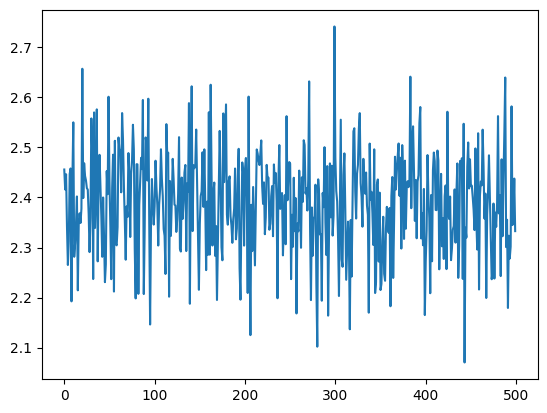

In [9]:
init_lr = 1e-1 # Initial learning rate
final_lr = 1e-2 # Final learning rate
max_iters = 50000

# Mini-batch gradient descent
losses = []
for i in range(max_iters):

    ix = torch.randint(0, x_train.shape[0], (batch_size, )) # Mini-batches
    xb, yb = x_train[ix], y_train[ix]

    # Forward pass
    emb = C[xb] # Embed characters into vectors (B,T) -> (B,T,C)
    emb = emb.view(emb.size(0), -1)  # Concatenate the embeddings (B,T,C) -> (B,TC)
    h_pre_act = emb @ W_hidden

    # Batch normalisation
    bn_mean_i = h_pre_act.mean(0, keepdim=True)
    bn_std_i = h_pre_act.std(0, keepdim=True)
    h_pre_act = bn_gain * (h_pre_act - bn_mean_i) / bn_std_i + bn_bias
    with torch.no_grad():
        bn_mean_live = 0.999 * bn_mean_live + 0.001 * bn_mean_i
        bn_std_live = 0.999 * bn_std_live + 0.001 * bn_std_i
        
    h = torch.tanh(h_pre_act)
    logits = h @ W_out + b_out

    # Cross entropy loss
    loss = F.cross_entropy(logits, yb)
    losses.append(loss.data)

    # Backward pass
    for param in params:
        param.grad = None # Set the gradient to zero
    loss.backward()

    # Update the parameters
    lr = init_lr if i < (max_iters / 2) else final_lr
    for param in params:
        param.data -= lr * param.grad

    if i % (max_iters // 10) == 0 or i == max_iters - 1:
        print(f'Iteration {i:2d} | Loss (Mini-Batch): {loss.data:.4f}')

# Plot the mini-batch loss
plt.plot(losses)

### Evaluate the Model on the Entire Training and Validation Sets

In [ ]:
@torch.no_grad()
def split_loss(split: str) -> None:
    """Evaluate the loss for the given split."""
    x, y = (x_train, y_train) if split == 'train' else (x_val, y_val)
    # Forward pass
    emb = C[x] # Embed characters into vectors (B,T) -> (B,T,C)
    emb = emb.view(emb.size(0), -1) # Concatenate the embeddings (B,T,C) -> (B,TC)
    h_pre_act = emb @ W_hidden
    # Batch normalisation
    h_pre_act = bn_gain * (h_pre_act - bn_mean_live) / bn_std_live + bn_bias
    h = torch.tanh(h_pre_act)
    logits = h @ W_out + b_out
    loss = F.cross_entropy(logits, y)
    print(f'{split.capitalize()} Loss: {loss.data}')

split_loss('train')
split_loss('val')

In [ ]:
# Sample from the model
for _ in range(5):
    out = []
    context = [0] * block_size # Initialise context to '...'

    while True:
        # Forward pass
        emb = C[torch.tensor([context])] # Embed characters into vectors (B,T) -> (B,T,C)
        emb = emb.view(emb.size(0), -1) # Concatenate the embeddings (B,T,C) -> (B,TC)
        h_pre_act = emb @ W_hidden
        # Batch normalisation
        h_pre_act = bn_gain * (h_pre_act - bn_mean_live) / bn_std_live + bn_bias
        h = torch.tanh(h_pre_act)
        logits = h @ W_out + b_out
        probs = F.softmax(logits, dim=1)

        # Sample the next character from the distribution for the current character index
        ix = torch.multinomial(probs, num_samples=1, replacement=True).item()
        context = context[1:] + [ix] # Shift the context window
        out.append(int_to_char[ix])
        if ix == 0:
            break # End of word
    print(''.join(out))

In [ ]:
# Visualise the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), int_to_char[i], ha='center', va='center', color='white')
plt.grid('minor')

The model has learned to a basic clustering of the characters (all the vowels are clustered together with similar vector embeddings). The embedding dimension was set to 2 for visualisation purposes. A higher embedding dimension (`n_embd = 10`) would likely improve the performance of the model.